In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn.apionly as sns

# from composition.analysis.load_sim import load_sim
# from composition.support_functions.checkdir import checkdir
# import composition.analysis.plotting_functions as plotting

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
def make_charge_energy_histogram(log_energy, charge, proton_mask, iron_mask, ax, plot_line=False):
    charge_bins = np.linspace(0, 6, 50)
    energy_bins = np.arange(6.2, 8.0, 0.05)
#     charge_bins = 50
#     energy_bins = 50
#     energy_bins = np.arange(6.2, 9.51, 0.05)
#     energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    proton_hist, xedges, yedges = np.histogram2d(log_energy[MC_proton_mask],
                                                 charge[MC_proton_mask],
                                                 bins=[energy_bins,
                                                       charge_bins],
                                                 normed=False)
    proton_hist = np.ma.masked_where(proton_hist == 0, proton_hist)
    iron_hist, xedges, yedges = np.histogram2d(log_energy[MC_iron_mask],
                                               charge[MC_iron_mask],
                                               bins=[energy_bins, charge_bins],
                                               normed=False)

    h = proton_hist / (proton_hist + iron_hist)
    h = np.rot90(h)
    h = np.flipud(h)
    h = np.ma.masked_where(h == 0, h)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    def line_fit(array):
        fit = []
        for x in array:
            if x <= 9.0:
                slope = (5.3 - 2.55) / (9.5 - 6.2)
                fit.append(2.55 + slope * (x - 6.2))
            else:
                slope = (5.20 - 4.9) / (9.5 - 9.0)
                fit.append(4.9 + slope * (x - 9.0))
        fit = np.array(fit)
        return fit

    colormap = 'coolwarm'
    im = ax.imshow(h, extent=extent, origin='lower',
               interpolation='none', cmap=colormap,
               aspect='auto', vmin=0, vmax=1)
    x = np.arange(6.2, 9.51, 0.1)
    if plot_line:
        ax.plot(x, line_fit(x), marker='None', linestyle='--',
                 color='k')
    return im


number of events = 51608
[ 3.07516428  3.72994781  3.57956563 ...,  3.37126456  3.49191583
  3.76607233]
number of events = 51608
[ 3.05199001  3.29512616  3.57923469 ...,  3.34636361  3.25642122
  3.74266896]
number of events = 51589
[ 2.87058932  2.99652415  3.563019   ...,  3.1459832   2.8936624
  3.52259777]
number of events = 50592
[ 2.45170768  2.57714624  3.04401777 ...,  2.7257533   2.50205533
  2.82064943]


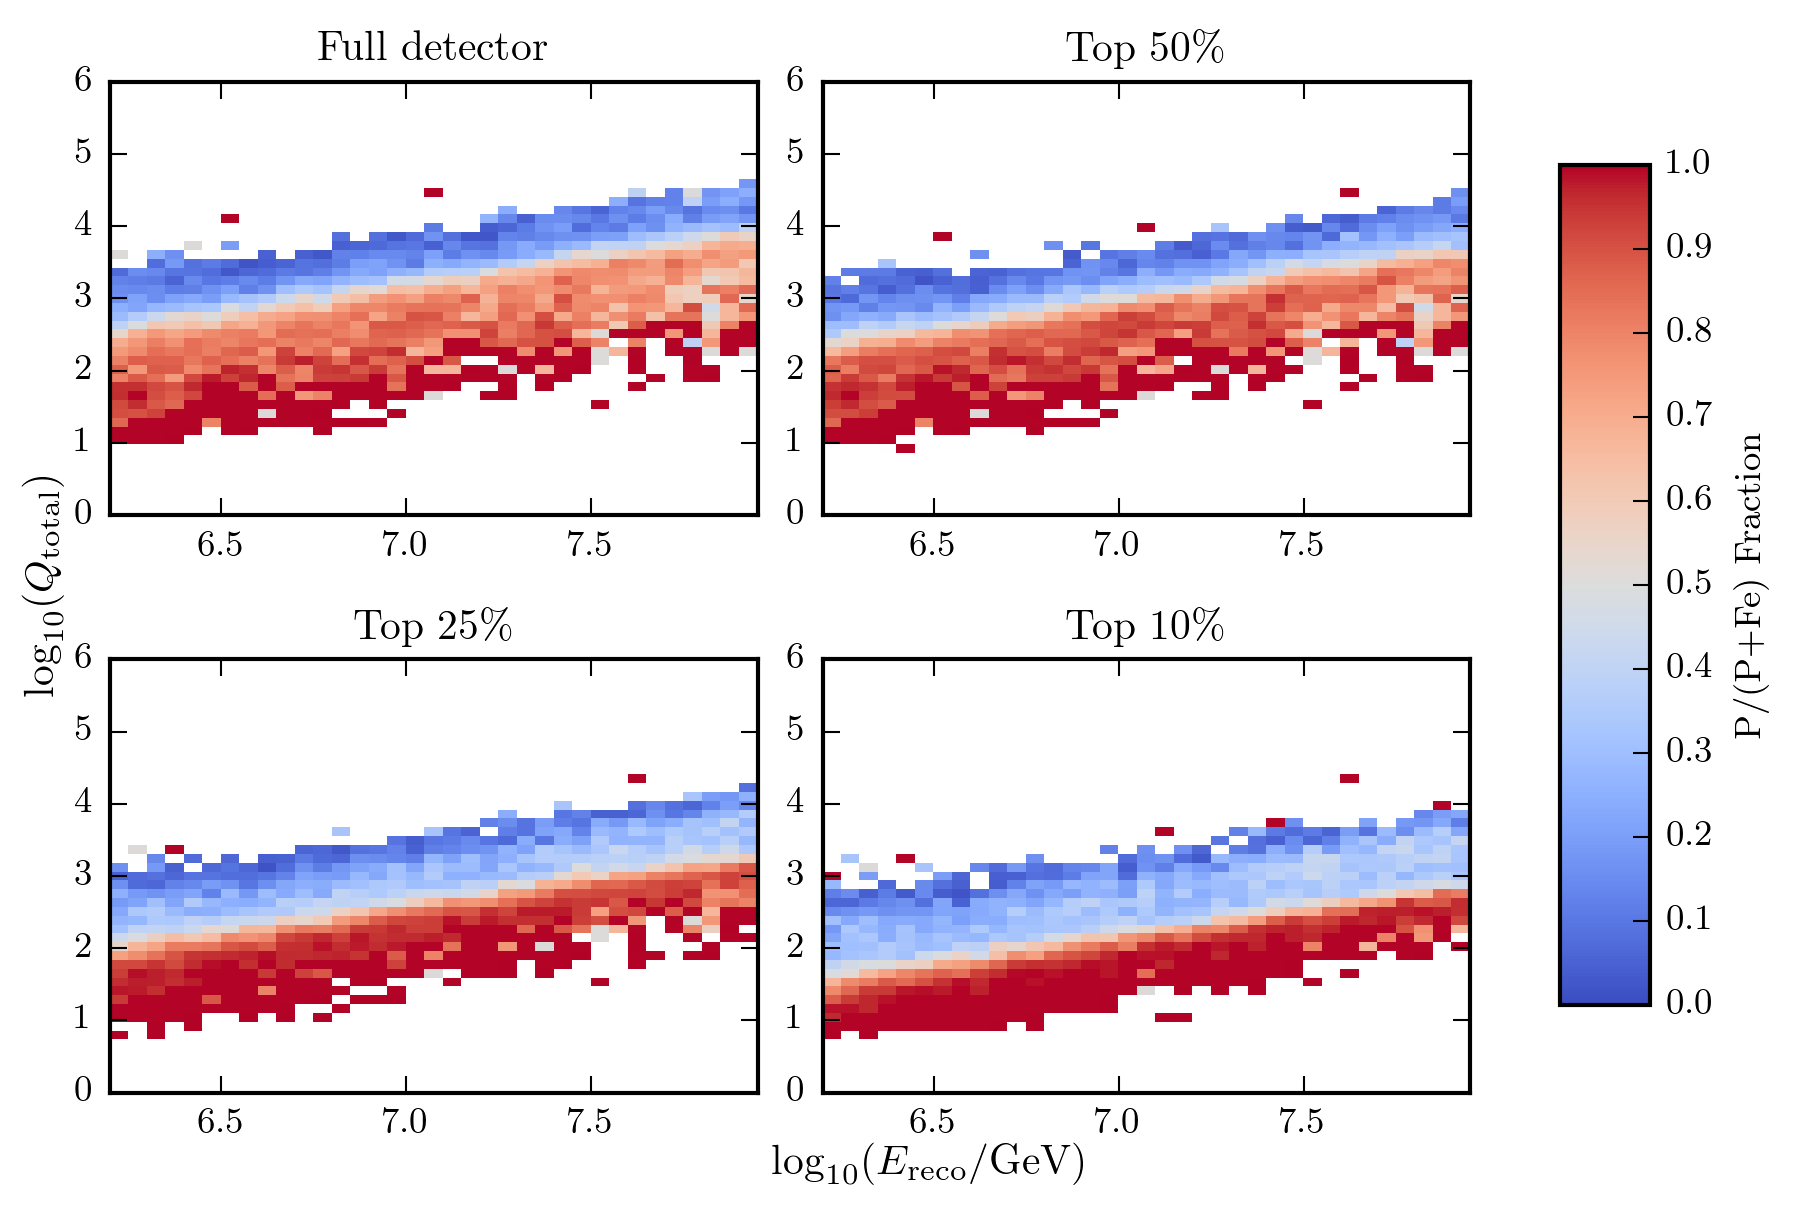

In [7]:
# charge_list = ['_1_60','_1_45', '_1_30', '_1_15']
# title_list = ['Full detector','Top 75\%', 'Top 50\%', 'Top 25\%']

charge_list = ['_1_60','_1_30', '_1_15', '_1_6']
title_list = ['Full detector','Top 50\%', 'Top 25\%', 'Top 10\%']

fig, axarr = plt.subplots(2,2)
for charge, title, ax in zip(charge_list, title_list, axarr.flatten()):
    # Import ShowerLLH sim reconstructions and cuts to be made
    df, cut_dict = comp.load_sim(return_cut_dict=True)
    selection_mask = np.array([True] * len(df))
    standard_cut_keys = ['reco_exists', 'reco_zenith', 'NStations', 'IT_signal',
                         'StationDensity', 'reco_containment', 'energy_range']
    for key in standard_cut_keys:
        selection_mask *= cut_dict[key]
    
#     selection_mask *= (df['LLHlap_InIce_containment'] < 1.0)
    selection_mask *= cut_dict['NChannels' + charge]
    selection_mask *= cut_dict['max_qfrac' + charge]
#     selection_mask *= (df['max_charge_frac{}'.format(charge)] < 0.3)
    df = df[selection_mask]
    print('number of events = {}'.format(len(df)))

    MC_proton_mask = (df.MC_comp == 'P')
    MC_iron_mask = (df.MC_comp == 'Fe')
    log_energy = df['reco_log_energy']
#     log_energy = df['log_s125']
    charge = np.log10(df['InIce_charge{}'.format(charge)])
    im = make_charge_energy_histogram(log_energy, charge, MC_proton_mask, MC_iron_mask, ax=ax)
    print(charge.values)
    ax.set_title(title)

fig.text(0.5, 0.00, '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', ha='center')
fig.text(0.00, 0.5, '$\log_{10}(Q_{\mathrm{total}})$', va='center', rotation='vertical')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='P/(P+Fe) Fraction')
# plt.colorbar(im, label='P/(P+Fe) Fraction')

In [2]:
from pandas.tools.plotting import parallel_coordinates

In [3]:
df = load_sim()
parallel_coordinates(df, class_column='MC_comp', cols=['InIce_charge', 'MC_energy'])

/home/jbourbeau/composition/analysis/load_sim.py:70: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))


Cut event flow:
                   reco_exists:  0.645  0.645
                   reco_zenith:  0.809  0.597
                      num_hits:  0.625  0.579
                     IT_signal:  0.227  0.218
                StationDensity:  0.787  0.218
              reco_containment:    0.5  0.169
               max_charge_frac:  0.775  0.169
                  energy_range:  0.447  0.117




RuntimeError: LaTeX was not able to process the following string:
'InIce_charge'
Here is the full report generated by LaTeX: 

This is pdfTeXk, Version 3.141592-1.40.3 (Web2C 7.5.6)
 %&-line parsing enabled.
entering extended mode
(./14e874c62740e610704d2634f5fc9462.tex
LaTeX2e <2005/12/01>
Babel <v3.8h> and hyphenation patterns for english, usenglishmax, dumylang, noh
yphenation, arabic, basque, bulgarian, coptic, welsh, czech, slovak, german, ng
erman, danish, esperanto, spanish, catalan, galician, estonian, farsi, finnish,
 french, greek, monogreek, ancientgreek, croatian, hungarian, interlingua, ibyc
us, indonesian, icelandic, italian, latin, mongolian, dutch, norsk, polish, por
tuguese, pinyin, romanian, russian, slovenian, uppersorbian, serbian, swedish, 
turkish, ukenglish, ukrainian, loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2005/09/16 v1.4f Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/psnfss/helvet.sty
(/usr/share/texmf/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/psnfss/courier.sty)
(/usr/share/texmf/tex/latex/base/textcomp.sty
(/usr/share/texmf/tex/latex/base/ts1enc.def))
(/usr/share/texmf/tex/latex/geometry/geometry.sty

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 14e874c62740e610704d2634f5fc9462.aux.
(/usr/share/texmf/tex/latex/base/ts1cmr.fd)
! Missing $ inserted.
<inserted text> 
                $
l.12 ...size{8.330000}{10.412500}{\rmfamily InIce_
                                                  charge}
! Extra }, or forgotten $.
l.12 ...330000}{10.412500}{\rmfamily InIce_charge}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./14e874c62740e610704d2634f5fc9462.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 14e874c62740e610704d2634f5fc9462.dvi (1 page, 312 bytes).
Transcript written on 14e874c62740e610704d2634f5fc9462.log.
